# **Modélisation et prévisions**

## Chargement des données

In [36]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 4.2 MB/s eta 0:00:30
    --------------------------------------- 2.4/124.9 MB 7.1 MB/s eta 0:00:18
   - -------------------------------------- 4.7/124.9 MB 8.9 MB/s eta 0:00:14
   -- ------------------------------------- 7.1/124.9 MB 9.9 MB/s eta 0:00:12
   --- ------------------------------------ 9.7/124.9 MB 10.4 MB/s eta 0:00:12
   --- ------------------------------------ 10.2/124.9 MB 9.2 MB/s eta 0:00:13
   --- ------------------------------------ 11.0/124.9 MB 8.7 MB/s eta 0:00:14
   --- ------------------------------------ 12.3/124.9 MB 8.0 MB/s eta 0:00:15
   ---- ----------------------------------- 13.9/124.9 MB 7.9 MB/s eta 0:00:14
   ---- ----------------------------------- 14.7/124.9 MB 8.0 MB/s eta 0:00:14



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\etudiant\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [15]:
# Base du projet
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))  # Utiliser le répertoire de travail actuel
# Charger les données contenant les features
FEATURES_DATA_PATH = os.path.join(BASE_DIR, "data", "features")
file_path = os.path.join(FEATURES_DATA_PATH, "telecom_sales_data_features.csv")
try:
    historical_data = pd.read_csv(file_path)
    print("Données des features chargées avec succès.")
    # Vérifier les colonnes disponibles
    print("Colonnes du DataFrame :", historical_data.columns.tolist())
except FileNotFoundError:
    print(f"Fichier introuvable : {file_path}")
except Exception as e:
    print(f"Erreur lors du chargement des données : {e}")


Données des features chargées avec succès.
Colonnes du DataFrame : ['marketing_score', 'competition_index', 'customer_satisfaction', 'purchasing_power_index', 'store_traffic', 'jPhone_Pro_revenue', 'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue', 'date', 'year', 'month', 'day', 'day_of_week', 'week_of_year', 'is_weekend', 'weather_condition_Bad', 'weather_condition_Good', '5g_phase_Early-5G', '5g_phase_Mature-5G', '5g_phase_Mid-5G', '5g_phase_Pre-5G', 'public_transport_Good', 'public_transport_Hub', 'public_transport_Poor']


In [24]:
historical_data['date'] = pd.to_datetime(historical_data['date'], errors='coerce')
if historical_data['date'].isnull().any():
    print("Les lignes avec des dates invalides sont :")
    print(historical_data[historical_data['date'].isnull()])
    raise ValueError("Des dates invalides sont présentes dans les données.")

In [34]:
# Identifier les colonnes cibles et features
target_columns = ['jPhone_Pro_revenue', 'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue']
feature_columns = historical_data.columns.difference(target_columns + ['date'] + ['store_traffic'] + ['weather_condition_Bad'] + ['weather_condition_Good'] + ['5g_phase_Early-5G'])

# Diviser les données en features et cibles
X_train = historical_data.loc[historical_data['date'] < pd.Timestamp('2025-01-01'), feature_columns]  # Features pour 2019-2024
y_train = historical_data.loc[historical_data['date'] < pd.Timestamp('2025-01-01'), target_columns]   # Cibles pour 2019-2024
X_future = historical_data.loc[historical_data['date'] >= pd.Timestamp('2025-01-01'), feature_columns]  # Features pour 2025

# Entraîner un modèle pour chaque cible
models = {}
future_predictions = {}
for target in target_columns:
    print(f"Entraînement du modèle pour {target}...")
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target])
    models[target] = model

    # Prédire pour 2025
    future_predictions[target] = model.predict(X_future)

# Convertir les prédictions en DataFrame
future_predictions_df = pd.DataFrame(future_predictions)

# Récupérer la colonne 'date' pour les données futures
future_predictions_df['date'] = historical_data.loc[historical_data['date'] >= pd.Timestamp('2025-01-01'), 'date'].values
print(future_predictions_df.head())




Entraînement du modèle pour jPhone_Pro_revenue...
Entraînement du modèle pour Kaggle_Pixel_5_revenue...
Entraînement du modèle pour Planet_SX_revenue...
   jPhone_Pro_revenue  Kaggle_Pixel_5_revenue  Planet_SX_revenue       date
0       110040.385900             53817.72140         29999.0352 2025-01-01
1       111852.466900             54453.81530         29496.5100 2025-01-02
2       115841.444000             57514.38420         30352.3863 2025-01-03
3       124164.431100             60514.46630         31896.4002 2025-01-04
4       125405.108233             60515.21045         31635.1174 2025-01-05


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Diviser les données en ensembles d'entraînement et de validation
train_data = historical_data.loc[historical_data['date'] < pd.Timestamp('2024-01-01')]
validation_data = historical_data.loc[
    (historical_data['date'] >= pd.Timestamp('2024-01-01')) &
    (historical_data['date'] < pd.Timestamp('2025-01-01'))
]

X_train = train_data[feature_columns]
y_train = train_data[target_columns]
X_val = validation_data[feature_columns]
y_val = validation_data[target_columns]

# Entraîner un modèle pour chaque cible
models = {}
metrics = {}
for target in target_columns:
    print(f"Entraînement du modèle pour {target}...")
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target])
    models[target] = model

    # Prédictions sur les données de validation
    y_val_pred = model.predict(X_val)

    # Calcul des métriques
    mae = mean_absolute_error(y_val[target], y_val_pred)
    mse = mean_squared_error(y_val[target], y_val_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val[target], y_val_pred)

    # Stocker les métriques
    metrics[target] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R^2": r2
    }

    print(f"Évaluation pour {target}:")
    print(f"  - MAE  : {mae}")
    print(f"  - MSE  : {mse}")
    print(f"  - RMSE : {rmse}")
    print(f"  - R^2  : {r2}")

# Résumé des métriques
metrics_df = pd.DataFrame(metrics).T
print("\nRésumé des performances :")
print(metrics_df)


Entraînement du modèle pour jPhone_Pro_revenue...
Évaluation pour jPhone_Pro_revenue:
  - MAE  : 13625.018915301845
  - MSE  : 365166787.2695918
  - RMSE : 19109.337698350297
  - R^2  : 0.25924745771128543
Entraînement du modèle pour Kaggle_Pixel_5_revenue...
Évaluation pour Kaggle_Pixel_5_revenue:
  - MAE  : 7809.505892331511
  - MSE  : 117909791.3269829
  - RMSE : 10858.627506595063
  - R^2  : 0.11560091986454868
Entraînement du modèle pour Planet_SX_revenue...
Évaluation pour Planet_SX_revenue:
  - MAE  : 5523.940534211555
  - MSE  : 49285203.401253454
  - RMSE : 7020.342114260063
  - R^2  : -0.3523981235208353

Résumé des performances :
                                 MAE           MSE          RMSE       R^2
jPhone_Pro_revenue      13625.018915  3.651668e+08  19109.337698  0.259247
Kaggle_Pixel_5_revenue   7809.505892  1.179098e+08  10858.627507  0.115601
Planet_SX_revenue        5523.940534  4.928520e+07   7020.342114 -0.352398


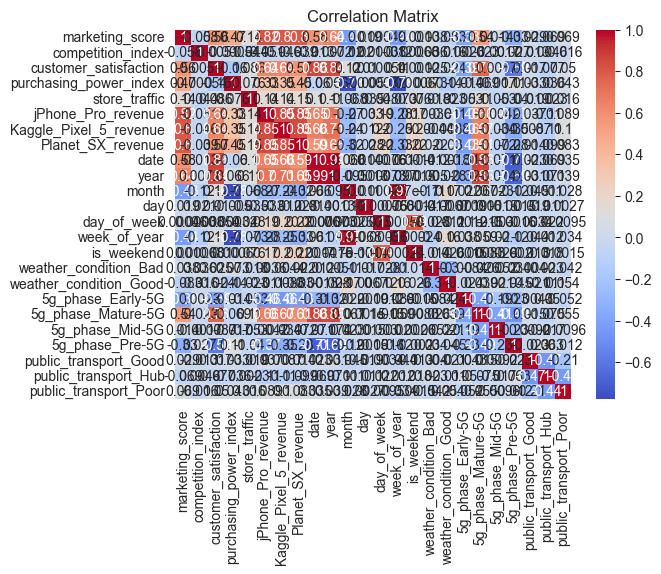

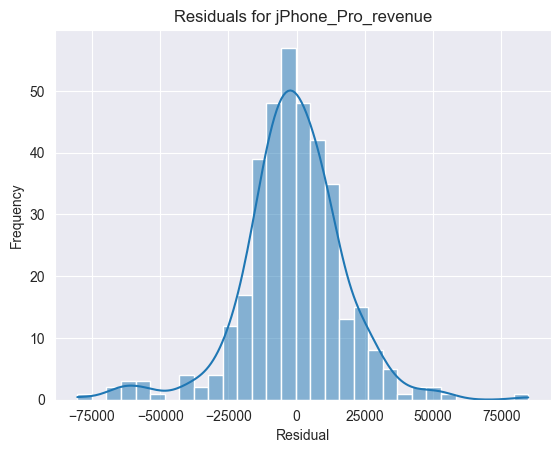

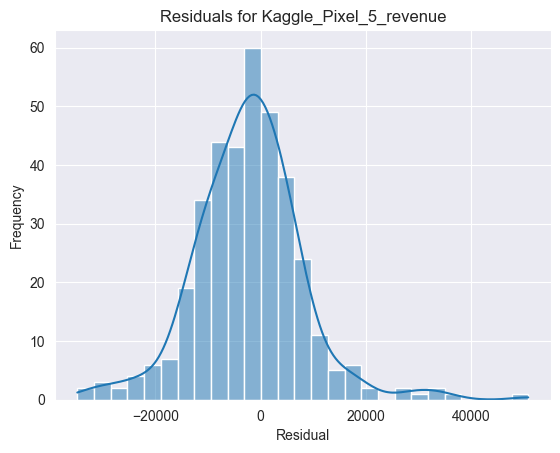

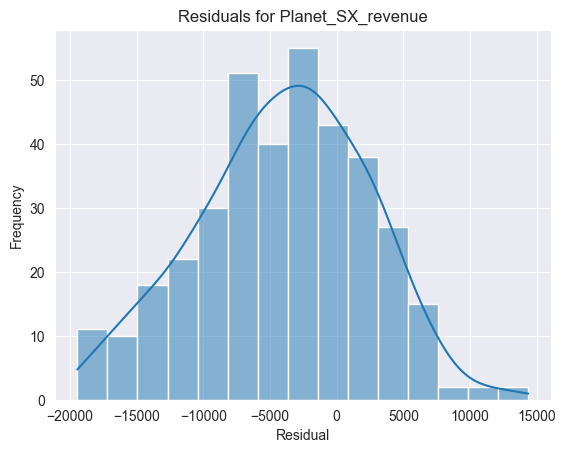

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Corrélation entre features et cibles
corr = historical_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Analyse des résidus (erreurs)
for target in target_columns:
    y_val_pred = models[target].predict(X_val)
    residuals = y_val[target] - y_val_pred
    sns.histplot(residuals, kde=True)
    plt.title(f"Residuals for {target}")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()


In [47]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Sélection des features essentielles et des colonnes temporelles
selected_features = [
    'year', 'month', 'day', 'day_of_week', 'week_of_year', 'is_weekend',
    'marketing_score', 'customer_satisfaction', 'purchasing_power_index', 'store_traffic', 'weather_condition_Bad', 'weather_condition_Good', '5g_phase_Early-5G', '5g_phase_Mature-5G', '5g_phase_Mid-5G', '5g_phase_Pre-5G', 'public_transport_Good', 'public_transport_Hub', 'public_transport_Poor'
]
target_columns = ['jPhone_Pro_revenue', 'Kaggle_Pixel_5_revenue', 'Planet_SX_revenue']

# Division des données en training et prédiction
X_train = historical_data.loc[historical_data['date'] < pd.Timestamp('2025-01-01'), selected_features]
y_train = historical_data.loc[historical_data['date'] < pd.Timestamp('2025-01-01'), target_columns]
X_future = historical_data.loc[historical_data['date'] >= pd.Timestamp('2025-01-01'), selected_features]

# Entraîner un modèle XGBoost pour chaque cible
models = {}
future_predictions = {}
for target in target_columns:
    print(f"Entraînement du modèle XGBoost pour {target}...")
    model = XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1, max_depth=6)
    model.fit(X_train, y_train[target])
    models[target] = model

    # Prédire pour 2025
    future_predictions[target] = model.predict(X_future)

# Ajouter les prédictions dans le DataFrame original
for i, target in enumerate(target_columns):
    historical_data.loc[historical_data['date'] >= pd.Timestamp('2025-01-01'), target] = future_predictions[target]

# Évaluer les performances
results = {}
for target in target_columns:
    y_pred_train = models[target].predict(X_train)
    mae = mean_absolute_error(y_train[target], y_pred_train)
    mse = mean_squared_error(y_train[target], y_pred_train)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train[target], y_pred_train)
    results[target] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R^2": r2}

# Afficher les résultats
performance_df = pd.DataFrame(results).T
print("\nRésumé des performances :")
print(performance_df)
display(historical_data[historical_data['date'] > pd.Timestamp('2025-01-01')])


Entraînement du modèle XGBoost pour jPhone_Pro_revenue...
Entraînement du modèle XGBoost pour Kaggle_Pixel_5_revenue...
Entraînement du modèle XGBoost pour Planet_SX_revenue...

Résumé des performances :
                                MAE           MSE         RMSE       R^2
jPhone_Pro_revenue      4446.887747  3.487325e+07  5905.357953  0.972409
Kaggle_Pixel_5_revenue  2153.526932  8.429272e+06  2903.320935  0.967685
Planet_SX_revenue       1057.188499  1.983405e+06  1408.334051  0.969923


,marketing_score,competition_index,customer_satisfaction,purchasing_power_index,store_traffic,jPhone_Pro_revenue,Kaggle_Pixel_5_revenue,Planet_SX_revenue,date,year,...,is_weekend,weather_condition_Bad,weather_condition_Good,5g_phase_Early-5G,5g_phase_Mature-5G,5g_phase_Mid-5G,5g_phase_Pre-5G,public_transport_Good,public_transport_Hub,public_transport_Poor
2193,92.655,29.990,71.97,90.17,-0.40,110824.484375,54539.839844,28887.250000,2025-01-02,2025,...,0,False,False,False,True,False,False,False,True,False
2194,92.800,30.025,71.98,90.26,-0.60,113700.875000,57588.078125,30264.556641,2025-01-03,2025,...,0,True,False,False,True,False,False,False,True,False
2195,92.950,30.060,71.98,90.34,0.29,127645.531250,63975.054688,31176.369141,2025-01-04,2025,...,1,True,False,False,True,False,False,False,True,False
2196,93.090,30.040,71.98,90.43,-0.57,128510.968750,63292.992188,31315.080078,2025-01-05,2025,...,1,False,False,False,True,False,False,False,True,False
2197,93.240,29.990,71.98,90.52,1.19,116690.406250,48480.660156,26582.814453,2025-01-06,2025,...,0,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,101.320,29.270,72.16,94.99,-0.47,112370.914062,68488.546875,31915.878906,2025-03-27,2025,...,0,False,True,False,True,False,False,False,False,True
2278,101.350,29.480,72.16,94.99,0.10,121264.585938,72294.882812,35276.828125,2025-03-28,2025,...,0,False,True,False,True,False,False,True,False,False
2279,101.370,29.650,72.16,95.00,0.15,137050.421875,82311.453125,40280.070312,2025-03-29,2025,...,1,False,True,False,True,False,False,False,True,False
2280,101.385,29.800,72.17,95.00,0.90,140167.093750,83554.679688,39088.785156,2025-03-30,2025,...,1,False,True,False,True,False,False,True,False,False


In [42]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
  Using cached shap-0.46.0-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.46.0-cp312-cp312-win_amd64.whl (456 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.7 MB 4.8 MB/s eta 0:00:01
   -------------------------------------- - 2.6/2.7 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 6.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   -- ------------------------------------- 1.6/28.1 MB 9.3 MB/s eta 0:00:03
   ----- ---------------------------------- 3.7/28.1 MB 9.5 MB/s eta 0:00:03
   -------- ------------------------------- 5.8/28.1 MB 9.8 MB/s eta 0:00:03
   ---------- ----------------------------- 7.6/28.1 MB 9.8 MB/s eta 0:00:03
   

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\etudiant\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


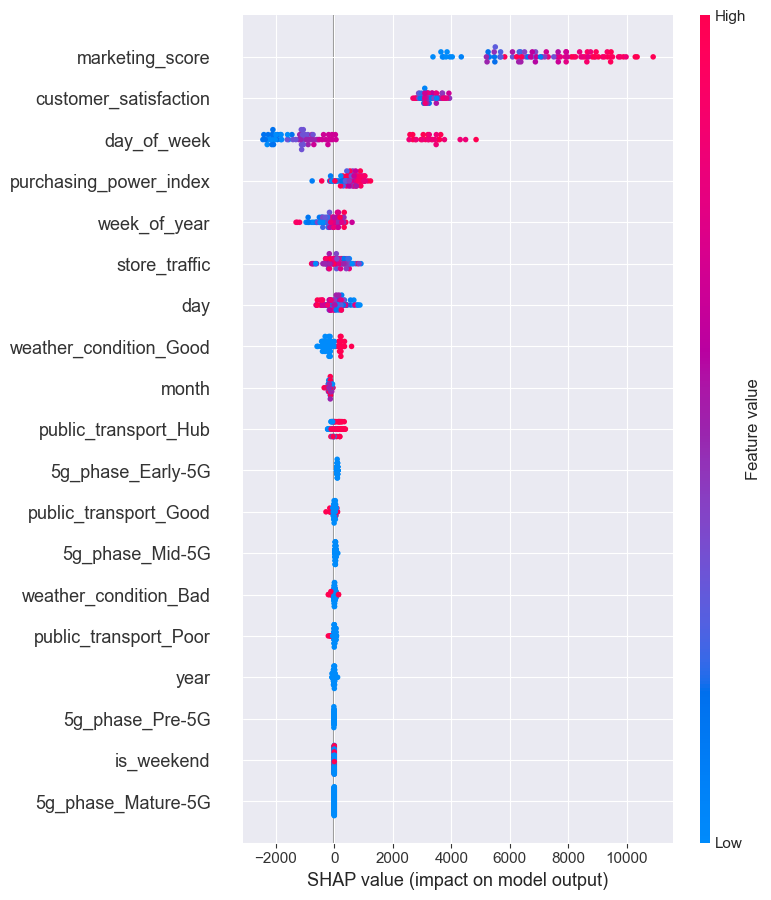

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [48]:
import shap

# Charger l'explainer SHAP pour votre modèle
explainer = shap.Explainer(model)  # Utilisez le modèle que vous avez entraîné
shap_values = explainer(X_future)  # Les features sur lesquelles expliquer

# Visualisation SHAP
shap.summary_plot(shap_values, X_future)  # Graphique global
shap.force_plot(explainer.expected_value, shap_values[0, :], X_future.iloc[0, :])  # Explication locale
